In [15]:
from tensorflow import keras
from tensorflow.keras.models import Model
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout
import numpy as np

In [16]:
import random
%matplotlib inline
from keras import backend as k
from PIL import Image
from numpy import zeros, newaxis
import cv2
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import tensorflow as tf

In [17]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        print(preds)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [30]:
model = keras.models.load_model('mask_model/mask_detector.model')

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [32]:
last_conv_layer_name = 'Conv_1'
classifier_layer_names = ['Conv_1_bn','out_relu','average_pooling2d','flatten','dense', 'dropout', 'dense_1']

In [33]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import os
import matplotlib.cm as cm
from IPython.display import Image

In [34]:
def print_grad(path):
    image_path = path
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image/255.
    img_array = image.reshape(1,224,224,3)

    heatmap = make_gradcam_heatmap(
        img_array, model, last_conv_layer_name, classifier_layer_names)
    heatmap = np.uint8(255 * heatmap)
    img = image
    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((224,224))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.005 + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    save_path = "test.jpg"
    superimposed_img.save(save_path)

    # Display Grad CAM
    display(Image(save_path))

tf.Tensor([[9.9995303e-01 4.7011530e-05]], shape=(1, 2), dtype=float32)


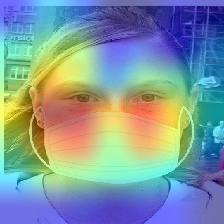

In [35]:
print_grad('Processed Dataset/with_ mask/100-with-mask.jpg')

tf.Tensor([[9.9990845e-01 9.1566093e-05]], shape=(1, 2), dtype=float32)


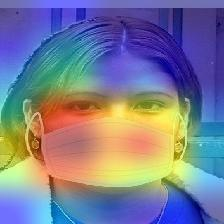

In [36]:
print_grad('Processed Dataset/with_ mask/107-with-mask.jpg')

tf.Tensor([[0.99306256 0.00693743]], shape=(1, 2), dtype=float32)


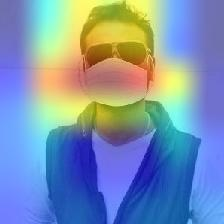

In [37]:
print_grad('Processed Dataset/with_ mask/116-with-mask.jpg')

tf.Tensor([[0.04994386 0.95005614]], shape=(1, 2), dtype=float32)


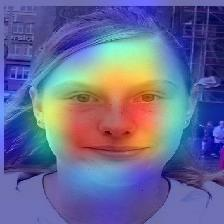

In [38]:
print_grad('Processed Dataset/without_ mask/100.jpg')

tf.Tensor([[0.03114954 0.9688505 ]], shape=(1, 2), dtype=float32)


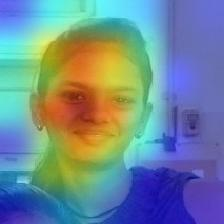

In [39]:
print_grad('Processed Dataset/without_ mask/105.jpg')

tf.Tensor([[0.00252174 0.9974783 ]], shape=(1, 2), dtype=float32)


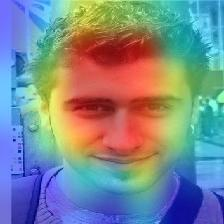

In [40]:
print_grad('Processed Dataset/without_ mask/119.jpg')